In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn import CrossEntropyLoss
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torchinfo import summary

from os.path import exists

from util import test_loss

In [4]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cuda


In [5]:
batch_size = 100

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data/CIFAR10', train=False,
                                       download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


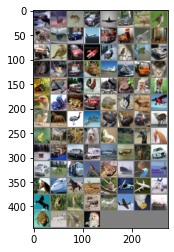

deer  deer  frog  car   plane car   bird  bird  deer  bird  car   plane truck truck bird  deer  truck bird  car   plane deer  bird  frog  car   frog  cat   ship  frog  plane ship  truck cat   car   plane truck bird  truck frog  dog   dog   bird  truck frog  car   frog  cat   deer  plane dog   horse bird  plane frog  bird  car   deer  frog  horse frog  dog   horse deer  bird  cat   deer  car   car   truck plane plane deer  car   car   horse truck bird  frog  ship  bird  plane horse ship  horse deer  bird  car   plane horse horse frog  deer  frog  horse plane dog   ship  frog  plane bird  dog  


In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [9]:
from Models import Cifar10_Net

input_shape = (100, 3, 32, 32)
num_labels = 10
expansion_rate = 3

NN_cif = Cifar10_Net(input_shape, num_labels, expansion_rate, device)

summary(NN_cif, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
Cifar10_Net                              [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 32, 26, 26]         4,736
│    └─CSC_block: 2-2                    [100, 64, 26, 26]         --
│    │    └─Sequential: 3-1              --                        19,136
│    └─CSC_block: 2-3                    [100, 128, 26, 26]        --
│    │    └─Sequential: 3-2              --                        75,136
│    └─AvgPool2d: 2-4                    [100, 128, 3, 3]          --
│    └─Flatten: 2-5                      [100, 1152]               --
│    └─Linear: 2-6                       [100, 64]                 73,792
│    └─ReLU: 2-7                         [100, 64]                 --
│    └─Linear: 2-8                       [100, 10]                 650
Total params: 173,450
Trainable params: 173,450
Non-trainable params:

In [10]:
PATH = "models/Cifar/Cifar10.pth"

if exists(PATH):
    NN_cif.load_state_dict(torch.load(PATH))
    NN_cif.eval()

In [11]:
criterion = CrossEntropyLoss()
optimizer_Cifar = optim.SGD(NN_cif.parameters(), lr=0.05, momentum=0.9)
scheduler_Cifar = optim.lr_scheduler.ExponentialLR(optimizer_Cifar, gamma=0.9)

In [15]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer_Cifar.zero_grad()

        # forward + backward + optimize
        outputs = NN_cif(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_Cifar.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 248:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] train_loss: {running_loss / 100:.3f}')
            running_loss = 0.0
            print(test_loss(NN_cif, test_dataloader, criterion))

    scheduler_Cifar.step()

In [ ]:
torch.save(NN_cif.state_dict(), "./models/Cifar/Cifar10.pth")

In [ ]:
NN2_cif = Cifar10_Net(input_shape, num_labels, expansion_rate)



PATH = "models/Cifar/Cifar10.pth"

if exists(PATH):
    NN2_cif.load_state_dict(torch.load(PATH))
    NN2_cif.eval()

print(test_loss(NN2_cif, test_dataloader, criterion))

(1.3544631683826447, 52.14)
